In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

### Inputs

In [14]:
input_file = 'PBI_L_pH_9and6_irr1to5min.csv'  # Input file name
base_name = os.path.splitext(input_file)[0]  # Remove .csv extension
cleaned_file = f"{base_name}_cleaned.csv" #autocreate cleaned and normilized file names
normalized_file = f"{base_name}_normalized.csv"
base_100 = True
base_0 = True
plot_baselines = False

In [15]:
min = 300
max = 800
step = 100

### Clean Data

In [16]:
df = pd.read_csv(input_file, header= None) # read file

In [17]:

df = df.astype(object)  # convert all columns to object dtype
df.iloc[0] = df.iloc[0].ffill()
df.dropna(subset=[df.columns[-2]], inplace = True) #drop rows with NaN in the last column - removed all the descriptive rows
df = df.dropna(axis=1) # remove any columns that have null values - incomplete data
df.columns = range(df.shape[1]) #reset column names after dropping columns
df.drop(columns= df.columns[(df.columns != 0) & (df.columns % 2 == 0)], inplace = True) #drop even numbered columns (repeats of wavelength)
df.iat[0, 0] = 'Wavelength (nm)' #set the first cell to be the wavelength column name
df.columns = df.loc[0] # set the first row as the column names
df.drop(index = [0, 1], inplace = True) # drop the two rows


In [18]:
df.to_csv(cleaned_file, index = False) # save data to cleaned csv file

### Normalize Data

In [19]:
skip_cols = 1  # first column = wavelength
if base_100:
    skip_cols += 1
if base_0:
    skip_cols += 1

In [20]:
df = df.loc[pd.to_numeric(df['Wavelength (nm)'], errors='coerce').between(min, max)]  #set the data range (300 to 800 nm)
scaler = MinMaxScaler()
df.loc[:, df.columns[skip_cols:]] = scaler.fit_transform(df[df.columns[skip_cols:]])

df.to_csv(normalized_file, index = False) # save normalized data to csv file

### Plot

In [21]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

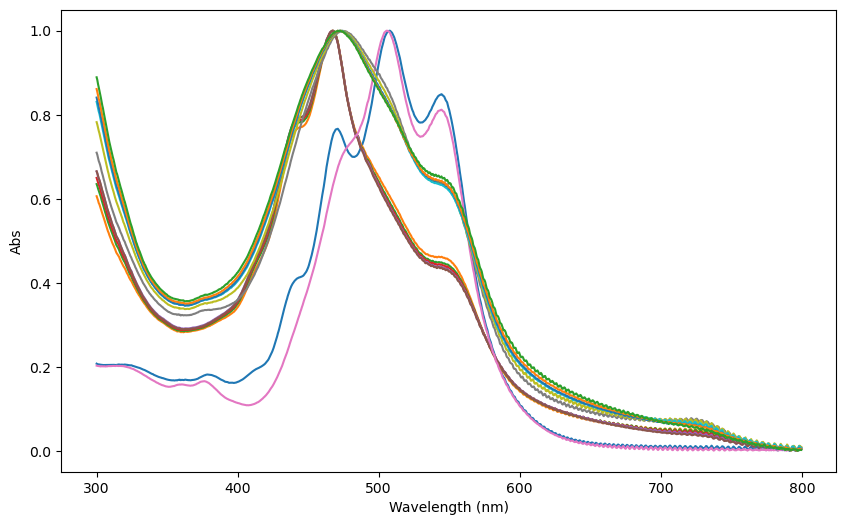

In [29]:
x = pd.to_numeric(df.iloc[:, 0]) # wavelength for x-axis

if plot_baselines:
    ys= df.iloc[:, 1:] # all other columns for y-axis
else:
    ys = df.iloc[:, skip_cols:]  # all other columns for y-axis, skipping the wavelength and baselines if they exist


plt.figure(figsize=(10,6))
for col in ys.columns:
    plt.plot(x, ys[col], label=str(col))
    
plt.xticks(np.arange(min, max + 1, step))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Abs')
plt.show()

### Inveractive Graph

In [34]:
import plotly.graph_objects as go

x = pd.to_numeric(df.iloc[:, 0]) # wavelength for x-axis

# Extract x-axis values
x = pd.to_numeric(df.iloc[:, 0])  # wavelength for x-axis 

# Extract y-axis values
if plot_baselines:
    ys = df.iloc[:, 1:]  # all other columns for y-axis
else:
    ys = df.iloc[:, skip_cols:]  # skip columns if necessary

# Create figure
fig = go.Figure()

# Add a line trace for each column in ys
for col in ys.columns:
    fig.add_trace(go.Scatter(
        x=x,
        y=ys[col],
        mode='lines',
        name=str(col)  # legend label
    ))

# Customize layout
fig.update_layout(
    title='Absorbance Spectrum',
    xaxis_title='Wavelength (nm)',
    yaxis_title='Abs',
    xaxis=dict(
        tickmode='linear',
        dtick=step,  # set tick step size
        range=[x.min(), x.max()]
    ),
    template='plotly_white',
    hovermode='x unified',
    showlegend = False
)

fig.show()

### Find Peaks

In [ ]:
from scipy.signal import find_peaks

# Use this if you haven't already defined x and ys
x = pd.to_numeric(df["Wavelength (nm)"])
ys = df.iloc[:, skip_cols:]  # Already normalized

# Loop through each spectrum (column)
for label in ys.columns:
    y = pd.to_numeric(ys[label])
    
    # Detect peaks (you can tune height/prominence as needed)
    peaks, properties = find_peaks(
        y,
        height=0.1,         # Only consider peaks with height > 0.2
        distance=3,        # Minimum distance (in data points) between peaks
        prominence=0.01     # Minimum vertical prominence of peaks
    )
    
    # Plot with peaks
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label=label)
    plt.plot(x.iloc[peaks], y.iloc[peaks], "rx", label="Peaks")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Abs")
    plt.show()

In [42]:
peak_dict = {}

for label in ys.columns:
    y = pd.to_numeric(ys[label])
    max_idx = y.idxmax()  # index of max absorbance
    max_wavelength = pd.to_numeric(x.loc[max_idx])
    peak_dict[label] = max_wavelength

# Print result
for trial, peak_wl in peak_dict.items():
    print(f"{trial}: Peak at {peak_wl:.2f} nm")

PBI_L_pH_9_5mgmL_0.05mm: Peak at 507.99 nm
PBI_L_pH_9_5mgmL_0.05mm_irr1min: Peak at 467.48 nm
PBI_L_pH_9_5mgmL_0.05mm_irr2min: Peak at 467.48 nm
PBI_L_pH_9_5mgmL_0.05mm_irr3min: Peak at 467.48 nm
PBI_L_pH_9_5mgmL_0.05mm_irr4min: Peak at 467.48 nm
PBI_L_pH_9_5mgmL_0.05mm_irr5min: Peak at 466.99 nm
PBI_L_pH_6_5mgmL_0.05mm: Peak at 506.01 nm
PBI_L_pH_6_5mgmL_0.05mm_irr1min: Peak at 473.98 nm
PBI_L_pH_6_5mgmL_0.05mm_irr2min: Peak at 472.99 nm
PBI_L_pH_6_5mgmL_0.05mm_irr3min: Peak at 472.49 nm
PBI_L_pH_6_5mgmL_0.05mm_irr4min: Peak at 472.49 nm
PBI_L_pH_6_5mgmL_0.05mm_irr5min: Peak at 471.00 nm
PBI_L_pH_6_5mgmL_0.05mm_irr10min: Peak at 471.00 nm
